In [1]:
%%capture
#%conda install -c plotly plotly=5.9.0
#%conda install pip
#%conda install twisted

%pip install plotly==5.9.0
%pip install twisted
%pip install pandas
%pip install ta    
%pip install scikit-learn
%pip install tensorflow
%pip install keras
%pip install matplotlib
%pip install scikeras
%pip install keras-tuner
%pip install plotly
%pip install nbformat
%pip install lightgbm
%pip install seaborn
%pip install s3cmd
#%curl https://storage.yandexcloud.net/yandexcloud-yc/install.sh | bash -s -- -a    
#%pip install huobi-sdk==2.3.3

import pandas as pd
import numpy as np    
import matplotlib.pyplot as plt
import plotly.express as px
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)



#print(f"Download completed. Local data dir: {data_dir}")

In [2]:
import os
# Downloading latest pytrade2 data
#os.system("cd ./../deploy/yandex_cloud; whereis yc; ./download_data.sh")

In [3]:
strategy='LgbLowHighRegressionStrategy'
target_period='5min'
data_dir=f"../data/yandex-cloud/{strategy}"
#lib_dir='../.venv/lib/python3.11/site-packages'
history_days=5
comission_pct=0.012
#comission_pct=0


## Read prediction data


In [4]:
from pathlib import Path

def read_last_data(pattern, days=1):

    xy_dir = Path(data_dir, 'Xy')
    files = sorted([f for f in os.listdir(xy_dir) if pattern in f])
                
    # Read last days' files to one dataframe
    df = pd.concat([pd.read_csv(Path(xy_dir, fname), parse_dates=[0]) for fname in files[-days:]])
    #df.columns=['close_time'] + list(df.columns[1:])
    #df['close_time'] = df['close_time'].astype('datetime64[ms]')
    #df = df.set_index('time')
    print(f'Read {len(df)} data {pattern} rows  from {df.index.min()} to {df.index.max()}')
    return df
    #return df.set_index('datetime')    
def read_signal(days = 1):
    df = read_last_data('signal_ext', days)
    #df.loc[df['signal'].diff()==0, 'signal'] = 0
    
    return df.set_index('datetime')

def read_candles(days = 1, period = '1min'):
    """ Read last days' 1 min candles from file system """
    candles_dir = Path(data_dir, 'Xy')
    files = sorted([f for f in os.listdir(candles_dir) if f'raw_candles_{period}' in f])
    # Read last days' files to one dataframe
    df = pd.concat([pd.read_csv(Path(candles_dir, fname)) for fname in files[-days:]])
    df[['open_time','close_time']] =df[['open_time','close_time']].astype('datetime64[ns]')
    df = df.set_index('close_time', drop=False)

    #del(df['close_time.1']) # temp fix
    # Resample because row data contains multiple candles inside a period
    print(f'Read {len(df)} candles from {df.index.min()} to {df.index.max()}')
    return df.resample(period).agg({'open_time': 'first', 'open': 'first', 'low': 'min', 'high': 'max', 'close': 'last', 'close_time': 'last'})

candles = read_candles(days=history_days, period=target_period)
#candles.tail()
signal_df = read_signal(days=history_days)
signal_df['signal'].value_counts()

Read 74703 candles from 2024-02-15 23:55:00 to 2024-02-20 07:50:00
Read 9858 data signal_ext rows  from 0 to 2745


signal
 0    8679
 1     682
-1     497
Name: count, dtype: int64

In [5]:
signal_df.tail()

signal  sl  tp    close  fut_low  fut_high  signal_buy  profit_buy  loss_buy  buy_ratio  signal_sell  profit_sell  loss_sell  sell_ratio
datetime                                                                                                                                                            
2024-02-20 07:48:41.687832       0 NaN NaN  51881.7  51848.6   51936.5       False        42.3      45.6        0.9        False         20.7       67.2         0.3
2024-02-20 07:49:13.761296       0 NaN NaN  51876.0  51838.4   51934.2       False        45.7      50.0        0.9        False         25.1       70.6         0.4
2024-02-20 07:49:43.843278       0 NaN NaN  51852.9  51826.8   51936.1       False        70.8      38.6        1.8        False         13.7       95.7         0.1
2024-02-20 07:50:15.909959       0 NaN NaN  51852.8  51824.5   51861.7       False        -3.6      40.8       -0.1        False         15.9       21.3         0.7
2024-02-20 07:50:45.992841       0 NaN NaN  51856.0  51829.4   51868.0       False        -0.5      39.1       -0.0        False         14.2       24.4         0.6

## Profit

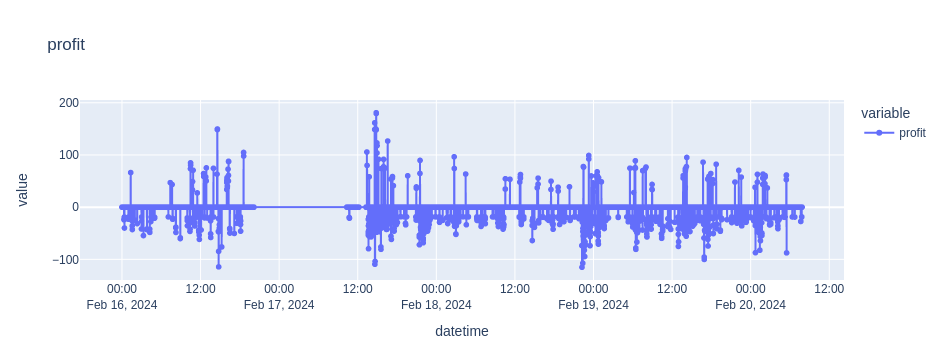

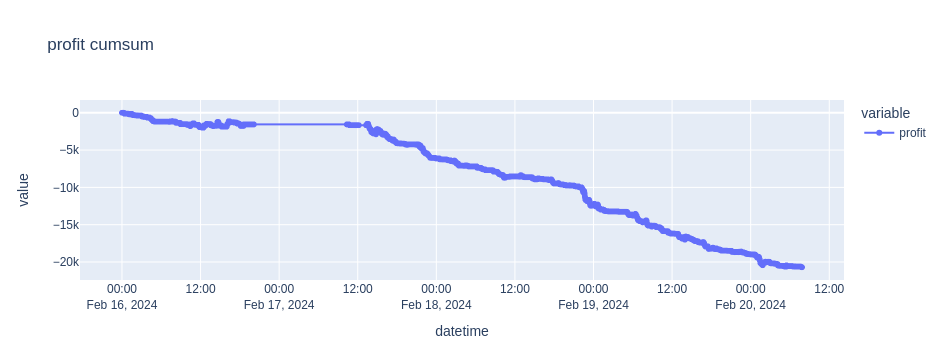

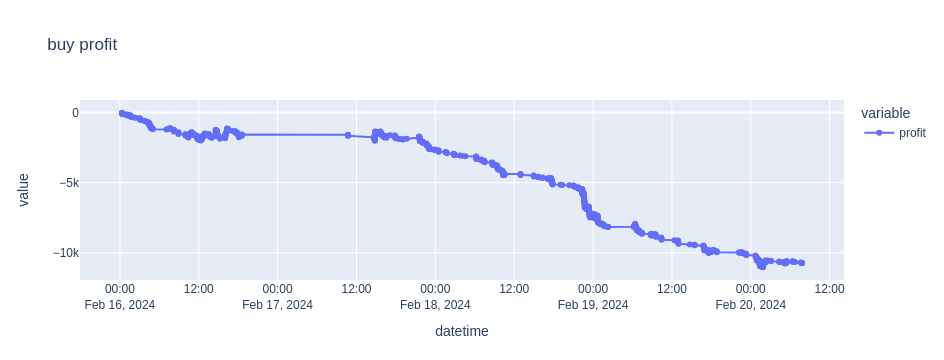

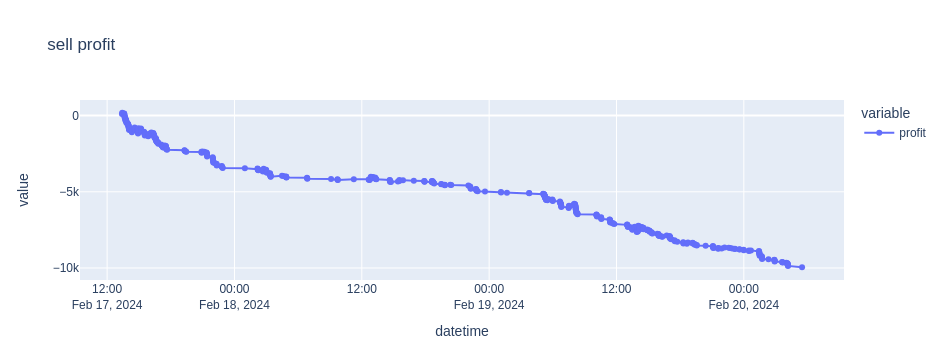

In [16]:
import plotly.express as px
import warnings
# Supress pandas+plotly warning
warnings.simplefilter(action='ignore', category=FutureWarning)

def calc_profit(y_signal, fut_lohi, candles, target_period):
    real_lohi = fut_lohi[['fut_low', 'fut_high']]
    real_lohi.columns=['fut_low_real', 'fut_high_real']
    y_signal = pd.merge_asof(y_signal.set_index(y_signal.index.astype('datetime64[ms]')),
                             real_lohi.set_index(real_lohi.index.astype('datetime64[ms]')), 
                             left_index=True, right_index=True, direction = 'backward')
    #y_signal['sl'] = y_signal['sl'] * (1-y_signal['signal']*comission_pct * 0.01 *2 )
    #y_signal['tp'] = y_signal['tp'] * (1+y_signal['signal']*comission_pct * 0.01 *2)

    # Consider only 1st signal in series
    #y_signal.loc[y_signal['signal'].diff()==0, 'signal'] = 0
    
    # Set profit/loss for 1 and -1, because 0 is excluded before
    profit = (y_signal['tp']-y_signal['close']).abs()
    loss = (y_signal['sl']-y_signal['close']).abs()

    is_buy_profit = ((y_signal['signal']==1) 
                     & (y_signal['sl']< y_signal['fut_low_real'])
                     & (y_signal['tp'] <= y_signal['fut_high_real'])
                    )
    is_buy_loss = (y_signal['signal']==1) & (~is_buy_profit)

    is_sell_profit = ((y_signal['signal']==-1) 
                     & (y_signal['sl'] > y_signal['fut_high_real']) 
                     & (y_signal['tp'] >= y_signal['fut_low_real']))
    is_sell_loss = (y_signal['signal']==-1) & (~is_sell_profit)

    # Calc profit
    profit_df = y_signal[['signal']].copy()
    profit_df.loc[is_buy_profit | is_sell_profit,['raw_profit']] = profit
    profit_df.loc[is_buy_loss | is_sell_loss, 'raw_profit'] = -loss
    profit_df['raw_profit'] = profit_df['raw_profit'].fillna(0)
    profit_df['profit'] = profit_df['raw_profit'] - y_signal['signal'].abs()*y_signal['close']*comission_pct*0.01*2

    #profit_df.loc[(profit_df['profit'] < 0) & (profit_df['signal'].diff()==0), ['profit', 'signal']] = 0,0
    #profit_df.loc[(profit_df['signal'].diff()==0), ['profit', 'signal']] = 0,0
    
    return profit_df

    
fut_lohi = candles[['low', 'high']].shift(-1).dropna().rename(columns={'low': 'fut_low', 'high': 'fut_high'})
profit_df = calc_profit(signal_df, fut_lohi, candles, target_period)

px.line(profit_df[['profit']], title='profit').update_traces(mode='lines+markers').show()
px.line(profit_df[['profit']].cumsum(), title='profit cumsum').update_traces(mode='lines+markers').show()

px.line(profit_df.loc[profit_df['signal']==1, ['profit']].cumsum(), title='buy profit').update_traces(mode='lines+markers').show()
px.line(profit_df.loc[profit_df['signal']==-1, ['profit']].cumsum(), title='sell profit').update_traces(mode='lines+markers').show()


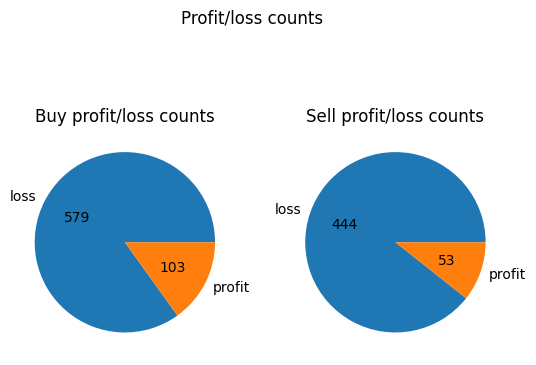

In [7]:
def plot_profit_pie(profit_df):
    fig, (ax1, ax2) = plt.subplots(1, 2) 
    df = profit_df.copy()
    df.loc[df['profit'] > 0, 'profit_status'] = 'profit'
    df.loc[df['profit'] < 0, 'profit_status'] = 'loss'
    vc1 = df.loc[df['signal'] == 1, 'profit_status'].value_counts()
    ax1.pie(vc1, labels=vc1.keys(), autopct= lambda x: '{:.0f}'.format(x*vc1.sum()/100))
    ax1.set_title('Buy profit/loss counts')
                  
    vc2 = df.loc[df['signal'] == -1, 'profit_status'].value_counts()
    ax2.pie(vc2, labels=vc2.keys(), autopct= lambda x: '{:.0f}'.format(x*vc2.sum()/100))
    ax2.set_title('Sell profit/loss counts')
    fig.suptitle('Profit/loss counts')
    plt.show()

plot_profit_pie(profit_df)
    

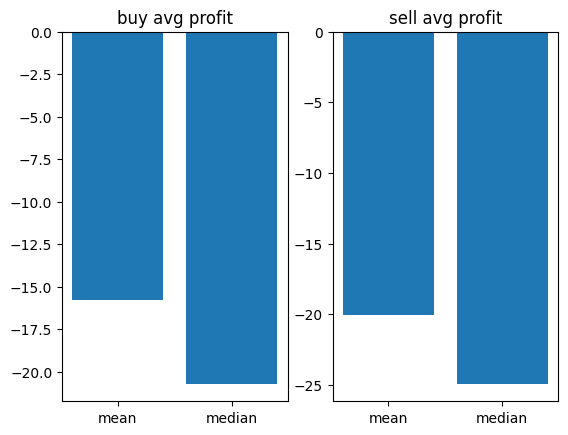

In [8]:

def plot_avg_profit(profit_df):
    fig, (ax1, ax2) = plt.subplots(1, 2) 
    buy_data = {'mean': profit_df[profit_df['signal'] == 1]['profit'].mean(), 
                'median': profit_df[profit_df['signal'] == 1]['profit'].median()}
    sell_data = {'mean': profit_df[profit_df['signal'] == -1]['profit'].mean(), 
                'median': profit_df[profit_df['signal'] == -1]['profit'].median()}
    ax1.bar(*zip(*buy_data.items()))
    ax1.set_title('buy avg profit')
    ax2.bar(*zip(*sell_data.items()))
    ax2.set_title('sell avg profit')
    plt.show()


plot_avg_profit(profit_df)

## Signal counts

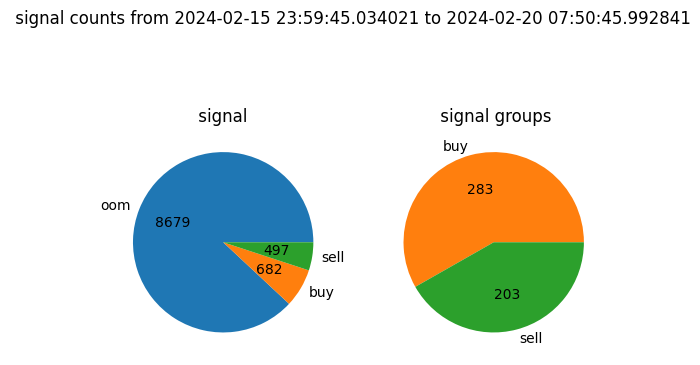

In [9]:
import matplotlib.pyplot as plt

def plot_value_counts(ax, df, col, grouped, name):
    signals = df[col]
    #vc = signals[signals.diff() != 0].value_counts()
    vc = df[col].value_counts() if not grouped else signals[(signals.diff() != 0) & (signals != 0)].value_counts()
    label_map={0:'oom', 1:'buy', -1: 'sell'}
    color_map={'oom':'C0', 'buy': 'C1', 'sell': 'C2'}
    labels = [ label_map[signal] for signal in vc.index.tolist()]
    colors = [color_map[key] for key in labels]
    ax.pie(vc, labels = labels,  autopct= lambda x: '{:.0f}'.format(x*vc.sum()/100), colors = colors)
    tag = 'groups' if grouped else ''
    ax.set_title(f"{name} {col} {tag}")
    
def plot_signal_counts(df, name = ''):
    #df = df.groupby('close_time').agg('last')
    fig, (ax1, ax2) = plt.subplots(1, 2) 
    plot_value_counts(ax1, df, 'signal', grouped = False, name=name)
    plot_value_counts(ax2, df, 'signal', grouped = True, name=name)
    fig.suptitle(f'{name} signal counts from {df.index.min()} to {df.index.max()}')
    plt.show()

plot_signal_counts(signal_df)

## Profits and losses

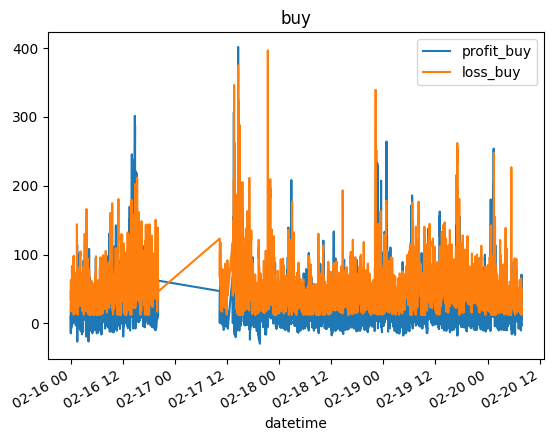

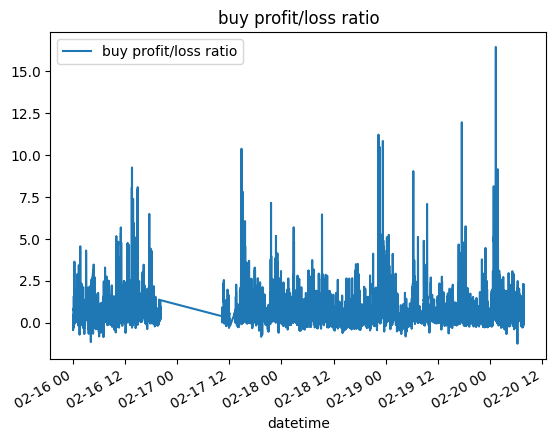

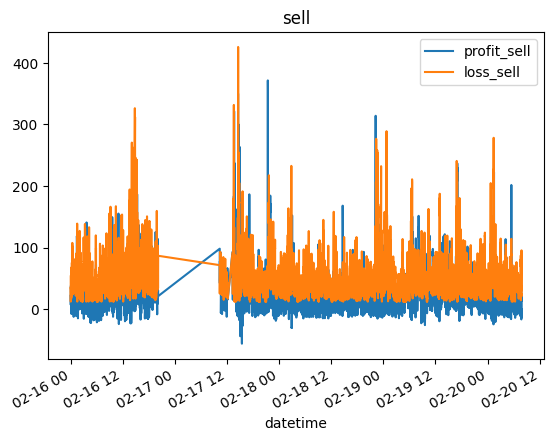

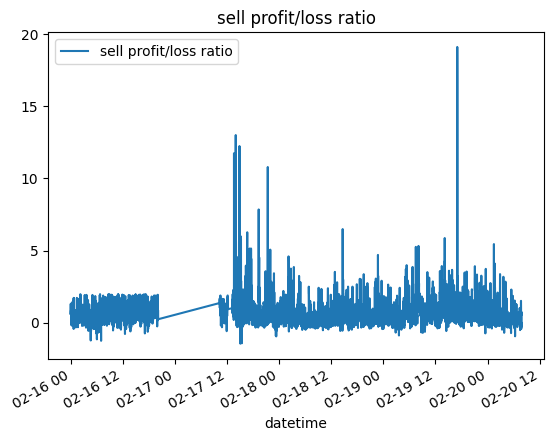

In [10]:
def plot_profit_loss(signalname):
    signal_df[[f'profit_{signalname}', f'loss_{signalname}']].plot(title=signalname)
    plt.show()
    ratio_df = pd.DataFrame(index=signal_df.index)
    ratio_df[f'{signalname} profit/loss ratio'] = (signal_df[f'profit_{signalname}']/signal_df[f'loss_{signalname}'])
    ratio_df.plot(title=f'{signalname} profit/loss ratio')
    plt.show()
plot_profit_loss('buy')
plot_profit_loss('sell')

## Profit/loss ratio

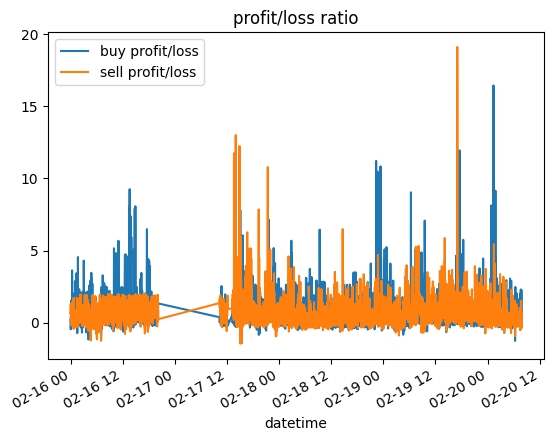

In [11]:
ratio_df = pd.DataFrame(index=signal_df.index)
ratio_df['buy profit/loss'] = (signal_df['profit_buy']/signal_df['loss_buy'])
ratio_df['sell profit/loss'] = (signal_df['profit_sell']/signal_df['loss_sell'])
ratio_df.plot(title='profit/loss ratio')

plt.show()


## Prices

In [12]:
import plotly as py
from plotly import graph_objects as go
import pandas as pd
import numpy as np
import datetime

def plot_candles_figure(signal_df: pd.DataFrame, candles: pd.DataFrame, period: str)->pd.DataFrame:
    """
    Form plotly candlestick chart with buy/sell marks on it
    """
    df = candles
    #df=signal_df.resample(period).agg('last')
    #df = df.merge(candles)
    
    #df=clean_candles(df)
    fig = go.Figure(data=[ \
                        go.Candlestick(\
                            x=df.index,\
                            open=df['close'].shift(1),\
                            high=df['high'],\
                            low=df['low'],\
                            close=df['close'])
                         ])
    

    fig.update_layout(title_text='Low/high candles')                         
    fig.show()

plot_candles_figure(signal_df, candles,  '5min')

In [13]:
def analyze_y():
    df = read_last_data('y_pred', 1)#.set_index('datetime')
    px.line(df[['fut_low_diff', 'fut_high_diff']]).update_traces(mode='lines+markers').show()

#def analyze_raw_candles()
analyze_y()


Read 1812 data y_pred rows  from 0 to 1811


In [14]:
def analyze_signal_df():
    df = signal_df.copy()
    c = candles[['low','high']]
    df = pd.merge_asof(df, candles, left_index=True, right_index=True, direction='backward')
    df['fut_low_diff'] = df['fut_low'] - df['low']
    df['fut_high_diff'] = df['fut_high'] - df['high']
    df['fut_low_diff_real'] = candles['low'].shift(-1) - candles['low']
    df['fut_high_diff_real'] = candles['high'].shift(-1) - candles['high']
    df = df[['fut_low_diff', 'fut_low_diff_real', 'fut_high_diff', 'fut_high_diff_real']]
    px.line(df).show()
    
analyze_signal_df()    